Code referenced from https://www.youtube.com/watch?v=CbTU92pbDKw

In [1]:
from helpers import *
from preprocessor import *

# Load the MIDI file
df = midi_get_df('classical-piano-type0_chpn-p19.mid')
df.head()

,note,start_time,end_time,duration
0,70,0.000000,0.000000,0.000000
1,70,0.000000,0.015789,0.015789
2,39,0.000000,0.015789,0.015789
3,58,0.015789,0.041959,0.026170
4,55,0.015789,0.041959,0.026170


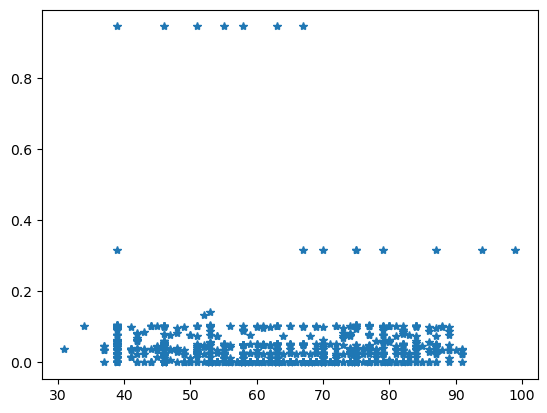

In [2]:
import matplotlib.pyplot as plt

plt.plot(df['note'], df['duration'], "*")

In [3]:
df = df[['start_time', 'note', 'duration']]
# df.index = df.pop('start_time') # set date as the index instead of numbering
df

,start_time,note,duration
0,0.000000,70,0.000000
1,0.000000,70,0.015789
2,0.000000,39,0.015789
3,0.015789,58,0.026170
4,0.015789,55,0.026170
...,...,...,...
1232,17.447794,55,0.944733
1233,17.447794,58,0.944733
1234,17.447794,51,0.944733
1235,17.447794,46,0.944733


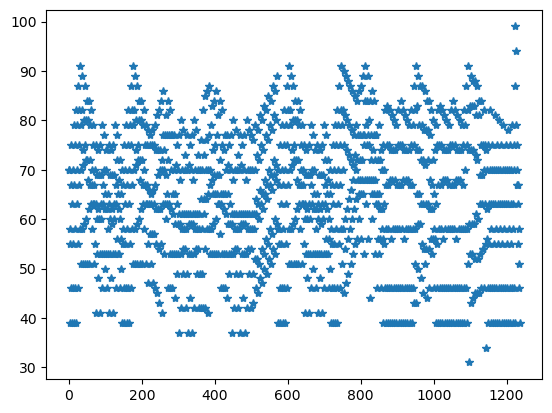

In [4]:
import matplotlib.pyplot as plt
plt.plot(df["note"], "*")

In [5]:
windowed_df = prepare_note_duration_data(df)
windowed_df

# target 1-3 are previous n values. This converts the inputs to the target output.

,start_time,duration_1,duration_2,duration_3,note_1,note_2,note_3,target_duration,target_note
0,0.000000,0.000000,0.015789,0.015789,70,70,39,0.026170,58
1,0.000000,0.015789,0.015789,0.026170,70,39,58,0.026170,55
2,0.000000,0.015789,0.026170,0.026170,39,58,55,0.052195,67
3,0.015789,0.026170,0.026170,0.052195,58,55,67,0.052195,46
4,0.015789,0.026170,0.052195,0.052195,55,67,46,0.104390,75
...,...,...,...,...,...,...,...,...,...
1228,16.503061,0.314911,0.314911,0.944733,70,75,63,0.944733,67
1229,16.503061,0.314911,0.944733,0.944733,75,63,67,0.944733,55
1230,17.447794,0.944733,0.944733,0.944733,63,67,55,0.944733,58
1231,17.447794,0.944733,0.944733,0.944733,67,55,58,0.944733,51


In [6]:
# time, X, y = windowed_df_to_date_X_y(windowed_df)
time = windowed_df["start_time"]
X = windowed_df[["duration_1", "note_1",
                "duration_2", "note_2",
                "duration_3", "note_3"]].to_numpy(dtype=np.float32)
X = X.reshape((X.shape[0], 3, 2))

y = windowed_df[["target_duration", "target_note"]]

time.shape, X.shape, y.shape

((1233,), (1233, 3, 2), (1233, 2))

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val, time_train, time_val = train_test_split(
    X, y, time, test_size=0.2, shuffle=False
)

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf


# --- Define model ---
model = Sequential([
    layers.Input((3, 2)),              # 3 timesteps, 2 features
    layers.LSTM(64),
    layers.Dense(32, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(2)                    # Output: duration, note
])

model.compile(
    loss=tf.keras.losses.Huber(),
    optimizer=Adam(learning_rate=0.001),
    metrics=['mae']
)

# --- Early stopping ---
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# --- Train ---
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    callbacks=[early_stop]
)

# --- Evaluate ---
loss, mae = model.evaluate(X_val, y_val)
print(f"Validation Loss: {loss:.4f}, MAE: {mae:.4f}")

# --- Predict ---
preds = model.predict(X_val)
print("Sample predictions:", preds[:5])


Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 31.3179 - mae: 31.6056 - val_loss: 28.0003 - val_mae: 28.2969
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 27.8116 - mae: 28.0860 - val_loss: 18.7730 - val_mae: 19.0460
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 15.0800 - mae: 15.3439 - val_loss: 6.3717 - val_mae: 6.6440
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.2855 - mae: 5.5474 - val_loss: 5.9762 - val_mae: 6.2488
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.0361 - mae: 5.2973 - val_loss: 5.5982 - val_mae: 5.8710
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.5044 - mae: 4.7655 - val_loss: 4.9972 - val_mae: 5.2713
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.1737 - mae: 4.4365 - val_loss: 4.3738 - val_mae: 4.6497
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.5610 - mae: 3.8366 - val_loss: 4.1713 - val_mae: 4.4676
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - l

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 590us/step


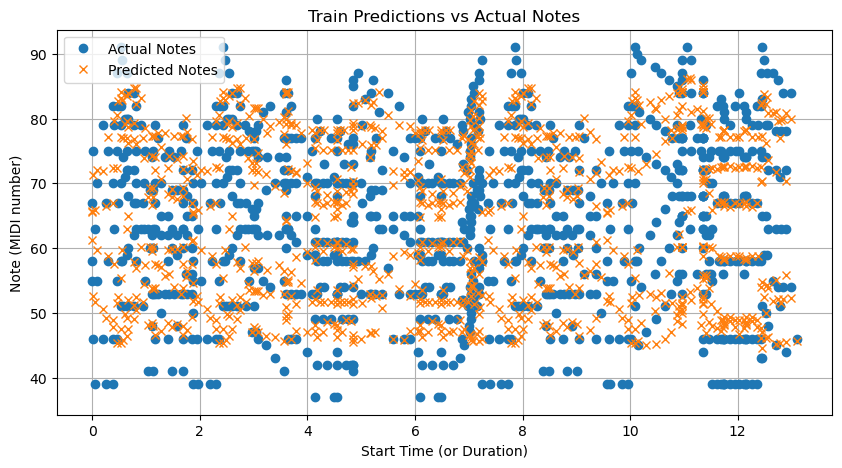

In [9]:
# --- Predict on train set ---
train_preds = model.predict(X_train)


# Plot train predictions vs actuals
plt.figure(figsize=(10, 5))
plt.plot(time_train, y_train["target_note"], 'o', label='Actual Notes')
plt.plot(time_train, train_preds[:,1], 'x', label='Predicted Notes')
plt.xlabel('Start Time (or Duration)')
plt.ylabel('Note (MIDI number)')
plt.title('Train Predictions vs Actual Notes')
plt.legend()
plt.grid(True)
plt.show()

Recall that we use a prev 3 day to predict current point. This is characteristics of a lagging controller. This is shown in the plots where the predictions lag behind the actual value. 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━

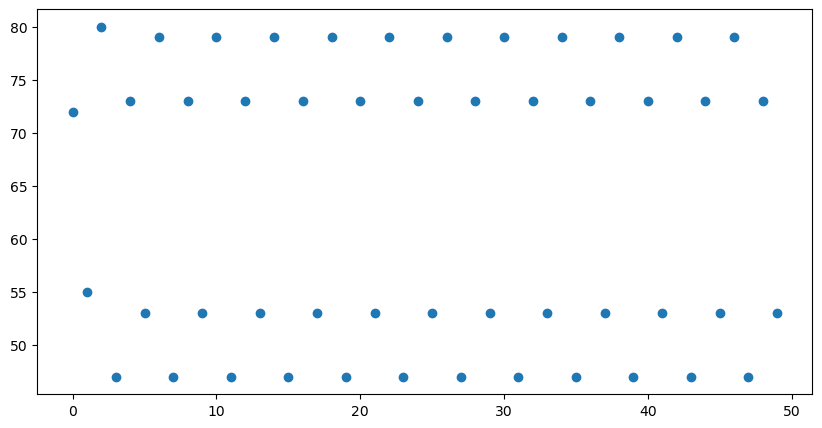

In [10]:
from sequential import *
# Usage:
initial_input = X_val[0]  # Example initial window from validation set
predicted_sequence = sequential_predict(model, initial_input, pred_steps=50)

plt.figure(figsize=(10, 5))

plt.plot(predicted_sequence[:,1], 'o', label='predicted sequence')